In [5]:
use_cuda = True
import torch

## Basic Wave Equation Solver

In [14]:
from WaveSolver import WaveSolver
from FNO import FNO1d

## Generate Dataset

In [15]:
waveSolver = WaveSolver()

xeVec = np.array([0.7, 0.3, 0.1]) # relative position
xeVec = np.random.rand(30)

num_param_steps = (waveSolver.numT-6) * xeVec.size
grid_size = waveSolver.numXs
training_input = torch.zeros(num_param_steps, grid_size,3)
training_output = torch.zeros(num_param_steps, grid_size,1)

index = 0

for xe in xeVec :
    # initial_condition = waveSolver.create_pluck(xe)
    initial_condition = waveSolver.create_random_initial()
    y_x = waveSolver.solve(initial_condition)

    for k in range(6,waveSolver.numT) :
        training_input[index,:,0] = torch.tensor(y_x[:,k-2])
        training_input[index,:,1] = torch.tensor(y_x[:,k-1])
        training_input[index,:,2] = torch.linspace(0,1, grid_size)
        training_output[index,:,0] = torch.tensor(y_x[:,k])
        index += 1


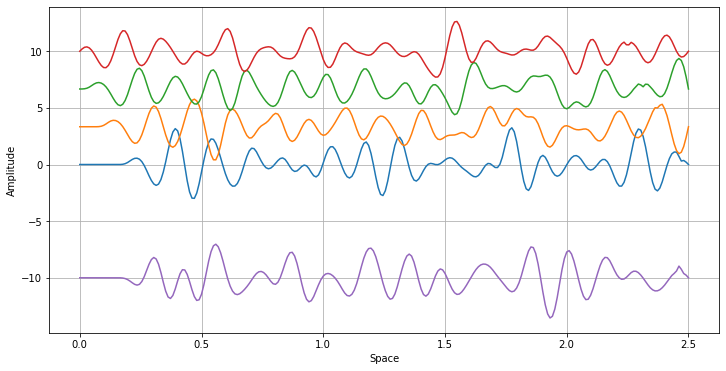

In [16]:
import matplotlib.pyplot as plt
fig, axs =  plt.subplots(figsize=(12, 6))
axs.plot(waveSolver.xs, y_x[:,[5, 20, 30, 40]] + np.linspace(0,1,4)*10)
axs.plot(waveSolver.xs, training_input[2,:,0] - 10)

axs.set_xlabel('Space')
axs.set_ylabel('Amplitude')
axs.grid(True)

# from matplotlib.animation import FuncAnimation
# fig = plt.figure(figsize=(15,15))
# ax = plt.axes(xlim=(0, 2.5), ylim=(-.2, .2))
# line, = ax.plot([], [], lw=2)
#
# x,y = [], []
# def animate(i):
#     line.set_data(waveSolver.xs, y_x[:,i])
#
# ani = FuncAnimation(fig, animate, interval=30)
# ani.save('WaveAnimation.mp4')

In [ ]:
modes = 128 # 32
width = 16 # 16

epochs = 50
learning_rate = 1e-4
batch_size = 64

if use_cuda :
    model = FNO1d(modes, width).to('cuda')
else :
    model = FNO1d(modes, width)


dataloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(training_input, training_output), batch_size=batch_size, shuffle=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = 1e-3, epochs=epochs, steps_per_epoch=len(dataloader))



for ep in range(epochs):
    for input, output in dataloader:
        if use_cuda :
            input, output = input.cuda(), output.cuda()
        optimizer.zero_grad()
        predicted_output = model(input)
        loss = torch.nn.functional.mse_loss(predicted_output, output)
        loss.backward()
        optimizer.step()
        scheduler.step()
    print("\r",'epochs:' + str(ep) + ', loss:' + str(loss.detach().cpu().numpy()), end = "")



Check output

In [ ]:
import matplotlib.pyplot as plt

grid_start = 0
grid_end = 1
test_grid_size = 64
field_val = 2

model_input = torch.zeros(1,grid_size,3)
model_output = torch.zeros(1,grid_size,1)

testNum = 20
timeSteps = 15
model_input[:,:,:] = training_input[testNum,:,:]
model_output[:,:,:] = training_output[testNum,:,:]
model_output[:,:,:] = training_output[testNum+timeSteps-1,:,:]

initial_condition = waveSolver.create_pluck(0.3) 
# initial_condition = waveSolver.create_random_initial()
y_x = waveSolver.solve(initial_condition)
model_input[0,:,0] = torch.tensor(y_x[:,testNum-2])
model_input[0,:,1] = torch.tensor(y_x[:,testNum-1])
model_output[0,:,0] = torch.tensor(y_x[:,testNum-0])
model_output[0,:,0] = torch.tensor(y_x[:,testNum-0+timeSteps-1])

input_field =  model_input[0,:,0]

if use_cuda :
    model_input = model_input.to('cuda')

for _ in range(timeSteps): # repeatedly predict next step
    model_result = model(model_input)
    model_input[:,:,0] = model_input[:,:,1]
    model_input[:,:,1] = model_result[:,:,0]

if use_cuda :
    model_output = model_output.cuda()

loss = torch.nn.functional.mse_loss(model_result, model_output)
print("\r",'loss:' + str(loss.detach().cpu().numpy()), end = "")

plt.figure()
plt.plot(input_field.data, label='input')
plt.plot(model_output[0,:,0].cpu().data + 10, label='next time step')
plt.plot(model_result.detach().cpu().flatten().numpy() + 20, label='predicted time step')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.) 